# Oil and Gas Production and Emissions Data on the Norwegian Continental Shelf

## Part 4

This is the fourth part of a series of notebooks that I am creating to analyze the oil and gas production and emissions data on the Norwegian Continental Shelf. The data is provided by the Norwegian Petroleum Directorate (NPD) and covers the period from 2001 to 2020. The data is available on the NPD website and can be downloaded from the following link: [Production and Emissions Data](https://factpages.sodir.no/).

You can find the other parts of the series here:

#### Part 1: [Data Collection](https://github.com/percw/Norwegian_oil_gas_decarbonization/blob/main/notebooks/01_data_building/01_production_and_emission_data_building.ipynb)

#### Part 2: [Data Cleaning](https://github.com/percw/Norwegian_oil_gas_decarbonization/blob/main/notebooks/02_data_cleaning/02_production_and_emission_data_cleaning.ipynb)

#### Part 3 [Data Processing](https://github.com/percw/Norwegian_oil_gas_decarbonization/blob/main/notebooks/03_data_processing/03_production_and_emission_data_processing.ipynb)

#### Part 5 [Data Optimization](https://github.com/percw/Norwegian_oil_gas_decarbonization/blob/main/notebooks/05_data_optimization/05_data_optimization.ipynb)


# Table of contents


## Imports


In [43]:
# Required Libraries
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from doubleml import DoubleMLData, DoubleMLPLR
from doubleml.datasets import fetch_bonus
from linearmodels.panel import PanelOLS
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                     train_test_split)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBRegressor

pd.set_option("display.max_columns", None)

# Define a function for calculating root mean squared error
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [44]:
# Importing the dataset from the csv file
filepath = "https://raw.githubusercontent.com/percw/Norwegian_oil_gas_decarbonization/main/data/output/emissions_and_production/cleaned/fields_prod_emissions_intensities_share_1997_2023.csv"

# Creating a check if import is successful
try:
    data = pd.read_csv(filepath, sep=",")
    print("Data import successful")
except:
    print("Data import failed")

Data import successful


## Estimating Electrification Effect Using TWFE

We want to check how electrification of the oil and gas platforms in the Norwegian Continental Shelf has affected emissions. We will use a Two Way Fixed Effects model to estimate the effect of electrification on emissions.


In [21]:
data.head(3)

,field,year,net_oil_prod_yearly_mill_sm3,net_gas_prod_yearly_bill_sm3,net_ngl_prod_yearly_mill_sm3,net_condensate_prod_yearly_mill_sm3,net_oil_eq_prod_yearly_mill_sm3,produced_water_yearly_mill_sm3,field_id,net_oil_prod_monthly_sm3_volatility,net_gas_prod_monthly_sm3_volatility,net_ngl_prod_monthly_sm3_volatility,net_condensate_prod_monthly_sm3_volatility,net_oil_eq_prod_monthly_sm3_volatility,produced_water_in_field_volatility,status,current_status,field_owner,processing_field,field_in_emissions,facilities_lifetime_mean,facilities_lifetime_std,facilities_water_depth_mean,facilities_water_depth_std,subsea_facilites_shut_down,surface_facilites_shut_down,subsea_facilites_in_service,surface_facilites_in_service,facility_kind_multi well template,facility_kind_single well template,facility_kind_offshore wind turbine,facility_kind_subsea structure,facility_kind_fpso,facility_kind_jacket 8 legs,facility_kind_condeep monoshaft,facility_kind_loading system,facility_kind_jacket 4 legs,facility_kind_jacket tripod,facility_kind_fsu,facility_kind_semisub steel,facility_kind_condeep 4 shafts,facility_kind_landfall,facility_kind_tlp concrete,facility_kind_jack-up 3 legs,facility_kind_jacket 6 legs,facility_kind_tlp steel,facility_kind_semisub concrete,facility_kind_mopustor,facility_kind_spar,well_status_closed,well_status_drilling,well_status_injecting,well_status_junked,well_status_online/operational,well_status_p&a,well_status_plugged,well_status_producing,well_status_suspended,well_purpose_injection,well_purpose_observation,well_purpose_production,well_subsea_no,well_subsea_yes,well_final_vertical_depth_mean,well_final_vertical_depth_std,well_water_depth_mean,well_water_depth_std,investments_mill_nok,future_investments_mill_nok,yearly_co2_emissions_1000_tonnes,org_number,operator,yearly_ch4_emissions_tons,yearly_nox_emissions_tons,yearly_oil_spill_emissions_tons,yearly_water_emissions_m3,ownership_original,ownership_new_name,current_remaining_recoverable_oil,current_remaining_recoverable_gas,current_remaining_recoverable_ngl,current_remaining_recoverable_condensate,current_remaining_recoverable_oe,original_recoverable_oil,original_recoverable_gas,original_recoverable_ngl,original_recoverable_condensate,original_recoverable_oe,electrified,years_electrified,electricity_mw,imported_power_2023_gwh/y,yearly_tco2e_gwp100,yearly_tco2e_gwp20,kgco2e/toe_int_gwp100,share_peak_prod,oe_cum_sum_prod,share_reserve_of_original_reserve,oe_fac_prod_mill_sm3,yearly_fac_tco2e_gwp100,oe_share_prod,yearly_tco2e_prod_share_emissions,share_intensity_tco2e/toe_gwp100,gas_reserve_ratio,oil_reserve_ratio,oil_gas_reserve_ratio
0,statfjord nord,1997,3.93531,0.17288,0.09230,0.00000,4.20051,0.0,43679,0.053898,0.000405,0.000334,0.000000,0.054005,0.0,Producing,Producing,21084.0,statfjord,True,27.5,15.0,241.75,65.030121,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,6.0,9.0,0.0,4.0,0.0,13.0,0.0,17.0,2888.8,0.000000,285.0,0.0,255.0,2946.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Den norske stats oljeselskap a.s': 50.0, 'Mo...","{'Equinor ASA': 1.875, 'Mobil Development Norw...",3.72,0.23,0.05,0.0,4.05,44.12,2.37,1.12,0.00,48.62,0,0,0,0.0,NaN,NaN,0.000000,100.0000,4.20051,91.360531,32.43504,3.153630e+06,0.129505,408411.794667,115.748925,0.000049,0.907445,18.616034
1,veslefrikk,1997,3.47468,0.13919,0.08596,0.00000,3.69981,0.0,43618,0.052851,0.008952,0.005461,0.000000,0.053418,0.0,Producing,Shut down,21212.0,veslefrikk,True,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111.0,0.0,0.0,69.0,6.0,36.0,111.0,0.0,3317.0,0.000000,175.0,0.0,229.0,0.0,156.20492,993246905.0,equinor energy as,64.319881,973.4661,88.599389,2782760.0,"{'Den norske stats oljeselskap a.s': 55.0, 'To...","{'Equinor ASA': 55.0, 'TotalEnergies EP Norge'...",0.00,0.00,0.00,0.0,0.00,55.34,4.19,1.81,0.00,62.97,0,0,0,0.0,446280.48203,449753.755604,143.5982

In [22]:
# Rename "kgco2e/toe_int_gwp100" to "emission_intensity" and "share_intensity_tco2e/toe_gwp100" to "emission_intensity_distributed"

data = data.rename(
    columns={
        "share_intensity_tco2e/toe_gwp100": "emission_intensity_distributed",
        "kgco2e/toe_int_gwp100": "emission_intensity",
    }
)

# Year is %Y datetime
data["year"] = pd.to_datetime(data["year"], format="%Y")

# Get emission tons
data["yearly_tco2_emissions"] = data["yearly_co2_emissions_1000_tonnes"] * 1000

# Remove nans, inf and -inf
#data = data.replace([np.inf, -np.inf], np.nan).dropna()

### TWFE


In [23]:
dependent_vars = [
    "emission_intensity",
    "emission_intensity_distributed",
    "yearly_tco2e_gwp100",
    "yearly_tco2e_prod_share_emissions",
]

# Define the control variables
control_vars = [
    "net_oil_eq_prod_yearly_mill_sm3",
    "share_reserve_of_original_reserve",
    #"net_oil_prod_yearly_mill_sm3",    # Removed: P-value increased
    #"net_gas_prod_yearly_bill_sm3",    # Removed: P-value increased
    #"share_peak_prod",                 # Removed: P-value increased
    #"original_recoverable_ngl",        # Removed: Fully absorbed
    #"original_recoverable_oe",         # Removed: Fully absorbed
]

# Step 1: Select only the necessary columns for the analysis
columns_needed = ["field_id", "year", "electrified"] + dependent_vars + control_vars
twfe_data = data[columns_needed].copy()

# Convert the 'year' column to a proper integer year if it contains timestamps
twfe_data["year"] = pd.to_datetime(twfe_data["year"], unit="ns").dt.year

# Ensure the 'year' column is of integer type
twfe_data["year"] = twfe_data["year"].astype(int)

# Step 2: Ensure no NaN values are present in the dependent variables or control variables
twfe_data = twfe_data.dropna(subset=dependent_vars + control_vars)

# Step 3: Create year dummies
year_dummies = pd.get_dummies(twfe_data["year"], prefix="year", drop_first=True)
twfe_data = pd.concat([twfe_data, year_dummies], axis=1)

# Step 4: Set the index to a MultiIndex (field_id, year) for panel data analysis
twfe_data = twfe_data.set_index(["field_id", "year"])


# Step 5: Function to perform Two Way Fixed Effects for a given dependent variable
def twfe_model(dependent_var, data, controls=None):
    year_cols = " + ".join(year_dummies.columns)
    formula = f"{dependent_var} ~ electrified + {year_cols} + EntityEffects"
    if controls:
        control_cols = " + ".join(controls)
        formula = f"{dependent_var} ~ electrified + {control_cols} + {year_cols} + EntityEffects"

    # Fit the Two Way Fixed Effects model
    model = PanelOLS.from_formula(formula, data, drop_absorbed=True).fit(
        cov_type="clustered", cluster_entity=True
    )

    return model


# Perform Two Way Fixed Effects model for each dependent variable without controls
results_no_controls = {}
for var in dependent_vars:
    model = twfe_model(var, twfe_data)
    if model is not None:
        non_treated_mean = twfe_data.loc[twfe_data["electrified"] == 0, var].mean()
        treatment_coefficient = model.params["electrified"]
        percentage_change = (treatment_coefficient / non_treated_mean) * 100

        results_no_controls[var] = {
            "model": model,
            "summary": model.summary,
            "coef": treatment_coefficient,
            "conf_int_lower": model.conf_int().loc["electrified"][0],
            "conf_int_upper": model.conf_int().loc["electrified"][1],
            "p_value": model.pvalues["electrified"],
            "non_treated_mean": non_treated_mean,
            "percentage_change": percentage_change,
        }

# Perform Two Way Fixed Effects model for each dependent variable with controls
results_with_controls = {}
for var in dependent_vars:
    model = twfe_model(var, twfe_data, controls=control_vars)
    if model is not None:
        non_treated_mean = twfe_data.loc[twfe_data["electrified"] == 0, var].mean()
        treatment_coefficient = model.params["electrified"]
        percentage_change = (treatment_coefficient / non_treated_mean) * 100

        results_with_controls[var] = {
            "model": model,
            "summary": model.summary,
            "coef": treatment_coefficient,
            "conf_int_lower": model.conf_int().loc["electrified"][0],
            "conf_int_upper": model.conf_int().loc["electrified"][1],
            "p_value": model.pvalues["electrified"],
            "non_treated_mean": non_treated_mean,
            "percentage_change": percentage_change,
        }

# Create summary tables for actual treatment effects
summary_table_no_controls = pd.DataFrame(results_no_controls).T
summary_table_no_controls = summary_table_no_controls[
    [
        "coef",
        "conf_int_lower",
        "conf_int_upper",
        "p_value",
        "non_treated_mean",
        "percentage_change",
    ]
]
summary_table_no_controls.columns = [
    "Coefficient",
    "CI Lower",
    "CI Upper",
    "P-value",
    "Non-treated Mean",
    "Percentage Change",
]

summary_table_with_controls = pd.DataFrame(results_with_controls).T
summary_table_with_controls = summary_table_with_controls[
    [
        "coef",
        "conf_int_lower",
        "conf_int_upper",
        "p_value",
        "non_treated_mean",
        "percentage_change",
    ]
]
summary_table_with_controls.columns = [
    "Coefficient",
    "CI Lower",
    "CI Upper",
    "P-value",
    "Non-treated Mean",
    "Percentage Change",
]

# Create a combined summary table
combined_summary = summary_table_no_controls.copy()
combined_summary["Coef (with controls)"] = summary_table_with_controls["Coefficient"]
combined_summary["CI Lower (with controls)"] = summary_table_with_controls["CI Lower"]
combined_summary["CI Upper (with controls)"] = summary_table_with_controls["CI Upper"]
combined_summary["P-value (with controls)"] = summary_table_with_controls["P-value"]
combined_summary["Percentage Change (with controls)"] = summary_table_with_controls[
    "Percentage Change"
]

print("\n\nComparison of TWFE Model Results without and with Controls:")
display(combined_summary)



Comparison of TWFE Model Results without and with Controls:


,Coefficient,CI Lower,CI Upper,P-value,Non-treated Mean,Percentage Change,Coef (with controls),CI Lower (with controls),CI Upper (with controls),P-value (with controls),Percentage Change (with controls)
emission_intensity,277.327391,-487.021438,1041.67622,0.476631,248.182898,111.743151,232.168019,-403.744507,868.080544,0.473882,93.547147
emission_intensity_distributed,-75.000273,-140.15967,-9.840875,0.024117,216.136113,-34.700482,-86.375462,-138.390513,-34.360412,0.001158,-39.963457
yearly_tco2e_gwp100,-176229.167329,-308263.28911,-44195.045548,0.008948,550447.046083,-32.015644,-154092.266384,-291669.72824,-16514.804529,0.028186,-27.994022
yearly_tco2e_prod_share_emissions,-190524.7641,-370216.390374,-10833.137826,0.037721,516962.247477,-36.854677,-140656.393761,-239913.267432,-41399.52009,0.005525,-27.208253


In [24]:
# Get the summary for emission_intensity_distributed
results_with_controls["emission_intensity_distributed"]["summary"]

Dep. Variable:,emission_intensity_distributed,R-squared:,0.1609
Estimator:,PanelOLS,R-squared (Between):,0.3090
No. Observations:,1093,R-squared (Within):,0.1609
Date:,"Thu, Jul 25 2024",R-squared (Overall):,0.2255
Time:,21:18:59,Log-likelihood,-6795.1
Cov. Estimator:,Clustered,,
,,F-statistic:,6.5144
Entities:,79,P-value,0.0000
Avg Obs:,13.835,Distribution:,"F(29,985)"
Min Obs:,1.0000,,
Max Obs:,27.000,F-statistic (robust):,5.0193


### DML 1: Remaining Reserve and Emission Intensity


/Users/pcw/opt/anaconda3/lib/python3.9/site-packages/doubleml/plm/plr.py:122: UserWarning: A learner ml_g has been provided for score = "partialling out" but will be ignored. "A learner ml_g is not required for estimation.
  warnings.warn(('A learner ml_g has been provided for score = "partialling out" but will be ignored. "'
/Users/pcw/opt/anaconda3/lib/python3.9/site-packages/doubleml/plm/plr.py:122: UserWarning: A learner ml_g has been provided for score = "partialling out" but will be ignored. "A learner ml_g is not required for estimation.
  warnings.warn(('A learner ml_g has been provided for score = "partialling out" but will be ignored. "'


Comparison of DML Model Results for Different Outcomes: 
(Treatment: share_reserve_of_original_reserve)


,Coefficient,Standard Error,T-Statistic,P-Value
emission_intensity_distributed,-0.425734,0.261054,-1.630828,0.102927
yearly_tco2e_prod_share_emissions,939.262882,382.762144,2.453907,0.014131


The quadratic equation for the total emissions is: y = -98.9381x^2 + 14171.6682x + 15607.2437
The quadratic equation for emission intensity is: y = 0.0265x^2 + -3.9068x + 306.2827


/Users/pcw/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


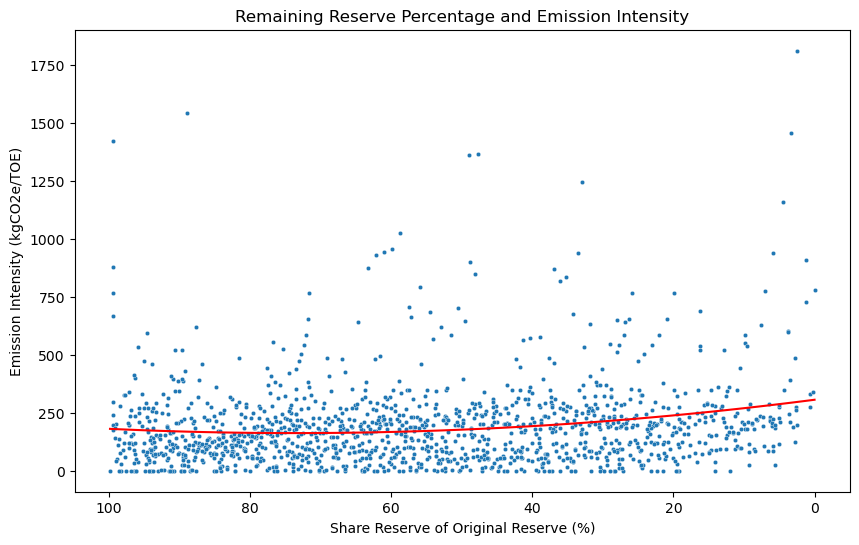

In [25]:
# Set random seeds for reproducibility
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures


random_seed = 42

# Copy the data for DML
data_dml_1 = data.copy()

# Remove fields with negative share_reserve_of_original_reserve
data_dml_1 = data_dml_1[data_dml_1["share_reserve_of_original_reserve"] >= 0]

# Generate the required variables
data_dml_1["processing_field_bin"] = (data_dml_1["processing_field"] == data_dml_1["field"]).astype(float)

# Create dummy variables for operator
field_owner_dummies = pd.get_dummies(data_dml_1["operator"], prefix="operator")
data_dml_1 = pd.concat([data_dml_1, field_owner_dummies], axis=1)

# Define the list of outcomes
outcomes = ["emission_intensity_distributed", "yearly_tco2e_prod_share_emissions"]

# Define the treatment and control variables
D = "share_reserve_of_original_reserve"
X = ["investments_mill_nok", "electrified"] + \
    [col for col in data_dml_1.columns if col.startswith("facilities")] + \
    [col for col in data_dml_1.columns if col.startswith("subsea_facilites")] + \
    [col for col in data_dml_1.columns if col.startswith("surface_")] + \
    [col for col in data_dml_1.columns if col.startswith("facility_kind")] + \
    [col for col in data_dml_1.columns if col.startswith("well_status")] + \
    [col for col in data_dml_1.columns if col.startswith("well_purpose")]

# Initialize a dictionary to store the summary statistics
dml_summary_stats = {}

# Iterate over the list of outcomes
for Y in outcomes:
    # Drop rows with NaN values in the relevant columns
    data_dml_1_clean = data_dml_1.dropna(subset=[Y, D] + X)
    
    # Initialize DoubleMLData object
    dml_data = DoubleMLData(data_dml_1_clean, Y, D, X)
    
    # Initialize DoubleMLPLR model with different models
    dml_plr = DoubleMLPLR(
        dml_data,
        ml_g=GradientBoostingRegressor(random_state=random_seed),
        ml_m=XGBRegressor(random_state=random_seed),
        ml_l=LinearRegression()
    )
    
    # Fit the model
    dml_plr.fit()
    
    # Extract the results
    coef = dml_plr.coef
    se = dml_plr.se
    t_stat = dml_plr.t_stat
    p_val = dml_plr.pval
    
    # Store the results in the dictionary
    dml_summary_stats[Y] = {
        "Coefficient": coef[0],
        "Standard Error": se[0],
        "T-Statistic": t_stat[0],
        "P-Value": p_val[0]
    }

# Convert the summary statistics dictionary to a DataFrame
dml_1_summary_df = pd.DataFrame(dml_summary_stats).T

# Display the summary DataFrame
print(f"Comparison of DML Model Results for Different Outcomes: \n(Treatment: {D})")
display(dml_1_summary_df)

# Fit a quadratic polynomial regression model to the total emissions
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(data_dml_1[["share_reserve_of_original_reserve"]])
model = LinearRegression()
model.fit(X_poly, data_dml_1["yearly_tco2e_prod_share_emissions"])

# Extract the coefficients
a, b, c = model.coef_[2], model.coef_[1], model.intercept_

print(f"The quadratic equation for the total emissions is: y = {a:.4f}x^2 + {b:.4f}x + {c:.4f}")

# Scatter plot with quadratic fit line
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=data_dml_1["share_reserve_of_original_reserve"],
    y=data_dml_1["emission_intensity_distributed"],
    s=10  # Marker size
)

# Fit a quadratic polynomial regression model
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(data_dml_1[["share_reserve_of_original_reserve"]])
model = LinearRegression()
model.fit(X_poly, data_dml_1["emission_intensity_distributed"])

# Extract the coefficients
a, b, c = model.coef_[2], model.coef_[1], model.intercept_

dml_1_equation = {
    "a": a,
    "b": b,
    "c": c
}

# Generate points for the fitted quadratic line
x_range = np.linspace(data_dml_1["share_reserve_of_original_reserve"].min(), data_dml_1["share_reserve_of_original_reserve"].max(), 100)
y_fit = model.predict(poly.transform(x_range.reshape(-1, 1)))

# Plot the fitted quadratic line
plt.plot(x_range, y_fit, color='red')

# Print the quadratic equation
print(f"The quadratic equation for emission intensity is: y = {a:.4f}x^2 + {b:.4f}x + {c:.4f}")

plt.xlabel("Share Reserve of Original Reserve (%)")
plt.ylabel("Emission Intensity (kgCO2e/TOE)")
plt.title("Remaining Reserve Percentage and Emission Intensity")
plt.gca().invert_xaxis()
plt.show()

### DML 2: Share of Peak Production and Emission Intenisity


/Users/pcw/opt/anaconda3/lib/python3.9/site-packages/doubleml/plm/plr.py:122: UserWarning: A learner ml_g has been provided for score = "partialling out" but will be ignored. "A learner ml_g is not required for estimation.
  warnings.warn(('A learner ml_g has been provided for score = "partialling out" but will be ignored. "'
/Users/pcw/opt/anaconda3/lib/python3.9/site-packages/doubleml/plm/plr.py:122: UserWarning: A learner ml_g has been provided for score = "partialling out" but will be ignored. "A learner ml_g is not required for estimation.
  warnings.warn(('A learner ml_g has been provided for score = "partialling out" but will be ignored. "'


Comparison of DML Model Results for Different Outcomes: 
(Treatment: share_peak_prod)


,Coefficient,Standard Error,T-Statistic,P-Value
emission_intensity_distributed,-1.276515,0.242947,-5.254298,1.485904e-07
yearly_tco2e_prod_share_emissions,3266.600750,431.363210,7.572738,3.654377e-14


The quadratic equation for the total emissions is: y = -48.4101x^2 + 8544.4965x + 162319.5209
The quadratic equation for emission intensity is: y = 0.0480x^2 + -7.9769x + 431.4258


/Users/pcw/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


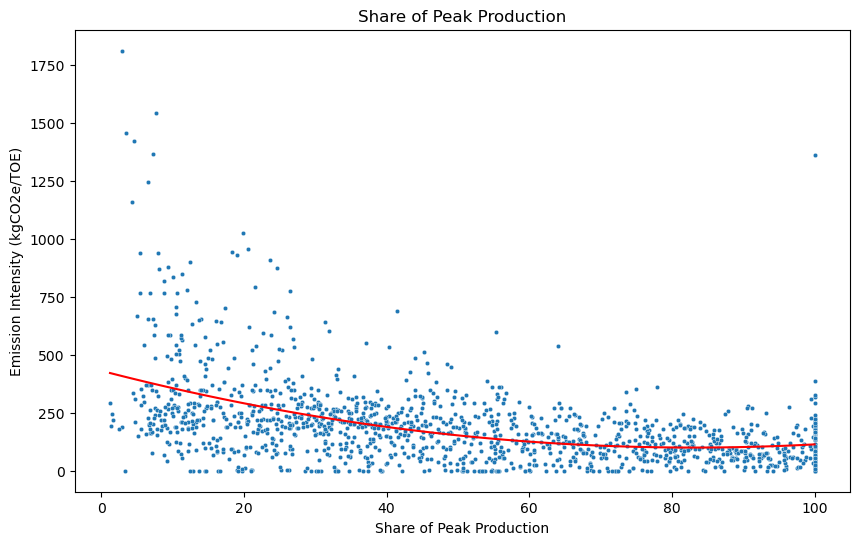

In [26]:
random_seed = 42

# Copy the data for DML
data_dml_2 = data.copy()

# Remove fields with negative share_reserve_of_original_reserve
data_dml_2 = data_dml_2[data_dml_2["share_peak_prod"] >= 0]

# Generate the required variables
data_dml_2["processing_field_bin"] = (data_dml_2["processing_field"] == data_dml_2["field"]).astype(float)

# Create dummy variables for operator
field_owner_dummies = pd.get_dummies(data_dml_2["operator"], prefix="operator")
data_dml_2 = pd.concat([data_dml_2, field_owner_dummies], axis=1)

# Define the list of outcomes
outcomes = ["emission_intensity_distributed", "yearly_tco2e_prod_share_emissions"]

# Define the treatment and control variables
D = "share_peak_prod"
X = ["investments_mill_nok", "electrified"] + \
    [col for col in data_dml_2.columns if col.startswith("facilities")] + \
    [col for col in data_dml_2.columns if col.startswith("subsea_facilites")] + \
    [col for col in data_dml_2.columns if col.startswith("surface_")] + \
    [col for col in data_dml_2.columns if col.startswith("facility_kind")] + \
    [col for col in data_dml_2.columns if col.startswith("well_status")] + \
    [col for col in data_dml_2.columns if col.startswith("well_purpose")]

# Initialize a dictionary to store the summary statistics
dml_summary_stats = {}

# Iterate over the list of outcomes
for Y in outcomes:
    # Drop rows with NaN values in the relevant columns
    data_dml_2_clean = data_dml_2.dropna(subset=[Y, D] + X)
    
    # Initialize DoubleMLData object
    dml_data = DoubleMLData(data_dml_2_clean, Y, D, X)
    
    # Initialize DoubleMLPLR model with different models
    dml_plr = DoubleMLPLR(
        dml_data,
        ml_g=GradientBoostingRegressor(random_state=random_seed),
        ml_m=XGBRegressor(random_state=random_seed),
        ml_l=LinearRegression()
    )
    
    # Fit the model
    dml_plr.fit()
    
    # Extract the results
    coef = dml_plr.coef
    se = dml_plr.se
    t_stat = dml_plr.t_stat
    p_val = dml_plr.pval
    
    # Store the results in the dictionary
    dml_summary_stats[Y] = {
        "Coefficient": coef[0],
        "Standard Error": se[0],
        "T-Statistic": t_stat[0],
        "P-Value": p_val[0]
    }

# Convert the summary statistics dictionary to a DataFrame
dml_2_summary_df = pd.DataFrame(dml_summary_stats).T

# Display the summary DataFrame
print(f"Comparison of DML Model Results for Different Outcomes: \n(Treatment: {D})")
display(dml_2_summary_df)

# Fit a quadratic polynomial regression model to the total emissions
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(data_dml_2[["share_peak_prod"]])
model = LinearRegression()
model.fit(X_poly, data_dml_2["yearly_tco2e_prod_share_emissions"])

# Extract the coefficients
a, b, c = model.coef_[2], model.coef_[1], model.intercept_

print(f"The quadratic equation for the total emissions is: y = {a:.4f}x^2 + {b:.4f}x + {c:.4f}")

# Scatter plot with quadratic fit line
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=data_dml_2["share_peak_prod"],
    y=data_dml_2["emission_intensity_distributed"],
    s=10  # Marker size
)

# Fit a quadratic polynomial regression model
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(data_dml_2[["share_peak_prod"]])
model = LinearRegression()
model.fit(X_poly, data_dml_2["emission_intensity_distributed"])

# Extract the coefficients
a, b, c = model.coef_[2], model.coef_[1], model.intercept_

dml_2_equation = {
    "a": a,
    "b": b,
    "c": c
}

# Generate points for the fitted quadratic line
x_range = np.linspace(data_dml_2["share_peak_prod"].min(), data_dml_2["share_peak_prod"].max(), 100)
y_fit = model.predict(poly.transform(x_range.reshape(-1, 1)))

# Plot the fitted quadratic line
plt.plot(x_range, y_fit, color='red')

# Print the quadratic equation
print(f"The quadratic equation for emission intensity is: y = {a:.4f}x^2 + {b:.4f}x + {c:.4f}")

plt.xlabel("Share of Peak Production")
plt.ylabel("Emission Intensity (kgCO2e/TOE)")
plt.title("Share of Peak Production")
plt.show()

### DML 3: Estimating emission based on Production Volume


/Users/pcw/opt/anaconda3/lib/python3.9/site-packages/doubleml/plm/plr.py:122: UserWarning: A learner ml_g has been provided for score = "partialling out" but will be ignored. "A learner ml_g is not required for estimation.
  warnings.warn(('A learner ml_g has been provided for score = "partialling out" but will be ignored. "'
/Users/pcw/opt/anaconda3/lib/python3.9/site-packages/doubleml/plm/plr.py:122: UserWarning: A learner ml_g has been provided for score = "partialling out" but will be ignored. "A learner ml_g is not required for estimation.
  warnings.warn(('A learner ml_g has been provided for score = "partialling out" but will be ignored. "'


Comparison of DML Model Results for Different Outcomes: 
(Treatment: net_oil_eq_prod_yearly_mill_sm3)


,Coefficient,Standard Error,T-Statistic,P-Value
emission_intensity_distributed,-10.824396,2.913631,-3.715089,0.000203
yearly_tco2e_prod_share_emissions,30602.101340,8528.415579,3.588252,0.000333


The quadratic equation for emission intensity is: y = 0.3122x^2 + -17.2239x + 244.5109


/Users/pcw/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


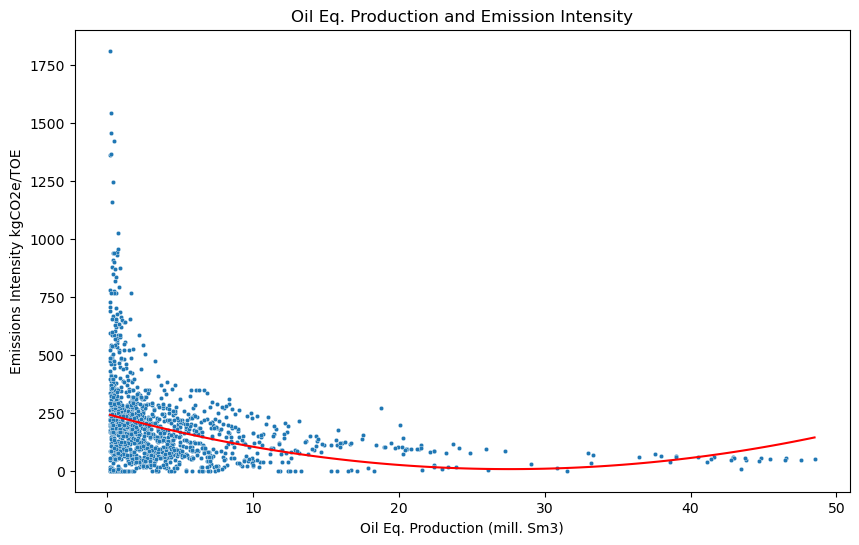

In [27]:
# Set random seeds for reproducibility
random_seed = 42

# Copy the data for DML
data_dml_3 = data.copy()

# Generate the required variables
data_dml_3["processing_field_bin"] = (data_dml_3["processing_field"] == data_dml_3["field"]).astype(float)

# Create dummy variables for operator
field_owner_dummies = pd.get_dummies(data_dml_3["operator"], prefix="operator")
data_dml_3 = pd.concat([data_dml_3, field_owner_dummies], axis=1)

# Define the list of outcomes
outcomes = ["emission_intensity_distributed", "yearly_tco2e_prod_share_emissions"]

# Define the treatment and control variables
D = "net_oil_eq_prod_yearly_mill_sm3"
X = ["investments_mill_nok", "electrified", "future_investments_mill_nok"] + \
    [col for col in data_dml_3.columns if col.startswith("facilities")] + \
    [col for col in data_dml_3.columns if col.startswith("subsea_facilites")] + \
    [col for col in data_dml_3.columns if col.startswith("surface_")] + \
    [col for col in data_dml_3.columns if col.startswith("facility_kind")] + \
    [col for col in data_dml_3.columns if col.startswith("well_status")] + \
    [col for col in data_dml_3.columns if col.startswith("well_purpose")]

# Initialize a dictionary to store the summary statistics
dml_summary_stats = {}

# Iterate over the list of outcomes
for Y in outcomes:
    # Drop rows with NaN values in the relevant columns
    data_dml_3_clean = data_dml_3.dropna(subset=[Y, D] + X)
    
    # Initialize DoubleMLData object
    dml_data = DoubleMLData(data_dml_3_clean, Y, D, X)
    
    # Initialize DoubleMLPLR model with different models
    dml_plr = DoubleMLPLR(
        dml_data,
        ml_g=GradientBoostingRegressor(random_state=random_seed),
        ml_m=XGBRegressor(random_state=random_seed),
        ml_l=LinearRegression()
    )
    
    # Fit the model
    dml_plr.fit()
    
    # Extract the results
    coef = dml_plr.coef
    se = dml_plr.se
    t_stat = dml_plr.t_stat
    p_val = dml_plr.pval
    
    # Store the results in the dictionary
    dml_summary_stats[Y] = {
        "Coefficient": coef[0],
        "Standard Error": se[0],
        "T-Statistic": t_stat[0],
        "P-Value": p_val[0]
    }

# Convert the summary statistics dictionary to a DataFrame
dml_1_summary_df = pd.DataFrame(dml_summary_stats).T

# Display the summary DataFrame
print(f"Comparison of DML Model Results for Different Outcomes: \n(Treatment: {D})")
display(dml_1_summary_df)

# Scatter plot with quadratic fit line
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=data_dml_3["net_oil_eq_prod_yearly_mill_sm3"],
    y=data_dml_3["emission_intensity_distributed"],
    s=10  # Marker size
)

# Fit a quadratic polynomial regression model
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(data_dml_3[["net_oil_eq_prod_yearly_mill_sm3"]])
model = LinearRegression()
model.fit(X_poly, data_dml_3["emission_intensity_distributed"])

# Extract the coefficients
a, b, c = model.coef_[2], model.coef_[1], model.intercept_

dml_3_equation = {
                  "a": a,
                  "b": b,
                  "c": c
                    }

# Generate points for the fitted quadratic line
x_range = np.linspace(data_dml_3["net_oil_eq_prod_yearly_mill_sm3"].min(), data_dml_3["net_oil_eq_prod_yearly_mill_sm3"].max(), 100)
y_fit = model.predict(poly.transform(x_range.reshape(-1, 1)))

# Plot the fitted quadratic line
plt.plot(x_range, y_fit, color='red')

# Print the quadratic equation
print(f"The quadratic equation for emission intensity is: y = {a:.4f}x^2 + {b:.4f}x + {c:.4f}")
plt.xlabel("Oil Eq. Production (mill. Sm3)")
plt.ylabel("Emissions Intensity kgCO2e/TOE")
plt.title("Oil Eq. Production and Emission Intensity")
plt.show()

## Predicting Future Production and Emissions


In [28]:
# Checking how many fields have more than 0 in current remaining recoverable oil eq.

data_producing = data[data["current_status"] == "Producing"]
data_producing[data_producing["current_remaining_recoverable_oe"] > 0]["field"].nunique()

85

In [29]:
data.net_oil_eq_prod_yearly_mill_sm3.describe()

count    1445.000000
mean        4.398490
std         6.904257
min         0.201610
25%         0.710210
50%         2.053830
75%         4.983730
max        48.502120
Name: net_oil_eq_prod_yearly_mill_sm3, dtype: float64

In [30]:
# Create a column called median_production for each field 
data["median_production"] = data.groupby("field")["net_oil_eq_prod_yearly_mill_sm3"].transform("mean")

# Checking Nan values in the median_production column
data["median_production"].isna().sum()

0

Dataset shape after preprocessing: (1274, 108)


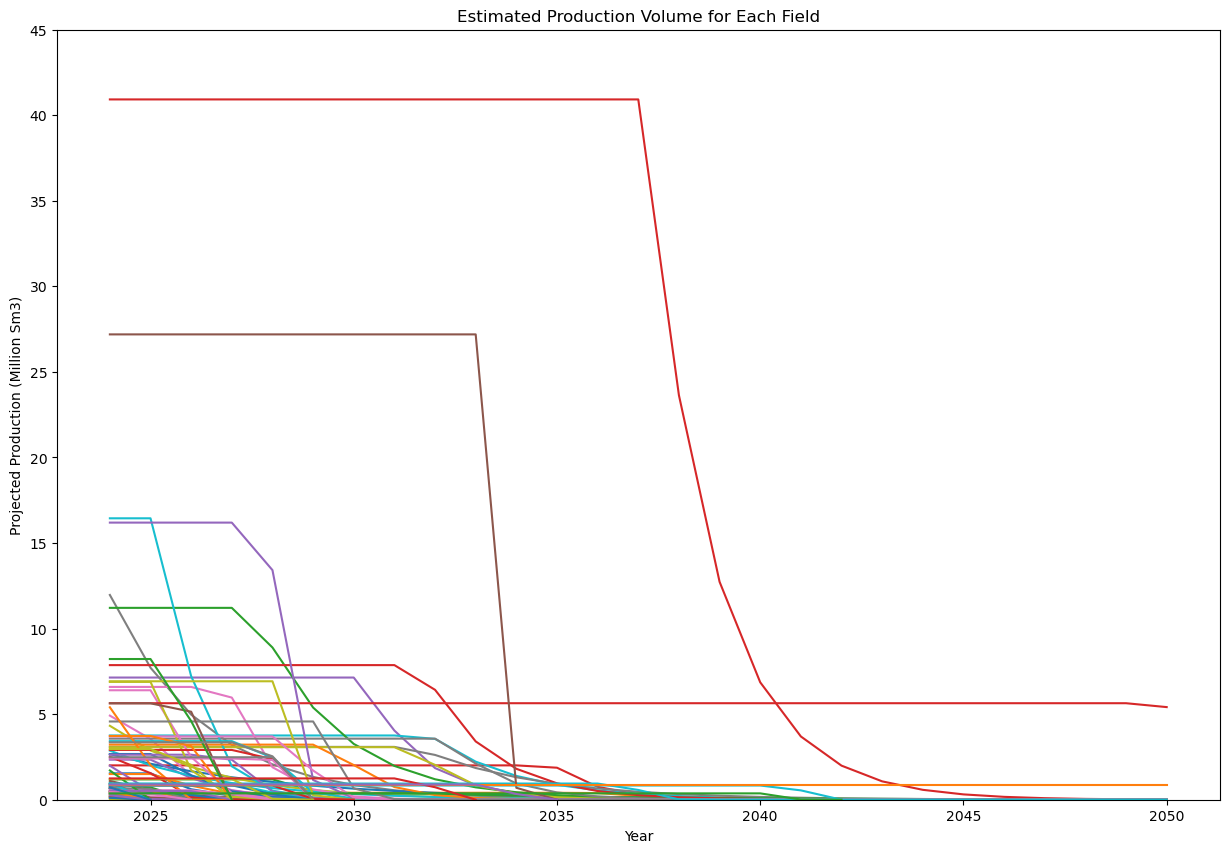

In [31]:
# Filter for producing fields and calculate median yearly production
producing_data = data.copy()
producing_data = producing_data[producing_data["current_remaining_recoverable_oe"] > 0]

# Define the ramp-down threshold
ramp_down_threshold = 0.05

# Print dataset information after preprocessing
print(f"Dataset shape after preprocessing: {producing_data.shape}")

# Simplified production forecast
future_years = list(range(2024, 2050))
fields = producing_data["field"].unique()

future_predictions = []

for field in fields:
    median_production = producing_data[producing_data["field"] == field]["median_production"].iloc[0]
    current_reserve = producing_data[producing_data["field"] == field]["current_remaining_recoverable_oe"].iloc[0]
    original_recoverable = producing_data[producing_data["field"] == field]["original_recoverable_oe"].iloc[0]
    cumulative_production = 0
    year = 2024

    while current_reserve > 0 and year <= 2050:
        if current_reserve <= ramp_down_threshold * original_recoverable:
            production_for_year = max(median_production * (current_reserve / (ramp_down_threshold * original_recoverable)), 0)
        else:
            production_for_year = median_production if current_reserve >= median_production else current_reserve

        cumulative_production += production_for_year
        future_predictions.append({
            "field": field,
            "year": year,
            "predicted_production": production_for_year,
            "cumulative_production": cumulative_production,
            "years_left": np.round(current_reserve / median_production, 0)
        })
        current_reserve -= production_for_year
        year += 1

    if current_reserve <= 0:
        future_predictions.append({
            "field": field,
            "year": year,
            "predicted_production": 0,
            "cumulative_production": cumulative_production,
            "years_left": 0
        })

# Create a DataFrame for future predictions
future_predictions_df = pd.DataFrame(future_predictions)

# Visualize the estimated production for each field
plt.figure(figsize=(15, 10))
for field in future_predictions_df["field"].unique():
    field_data = future_predictions_df[future_predictions_df["field"] == field]
    plt.plot(field_data["year"], field_data["predicted_production"], label=field)

plt.xlabel("Year")
plt.ylabel("Projected Production (Million Sm3)")
plt.title("Estimated Production Volume for Each Field")
plt.ylim(0, 45)  # Set the y-axis limit to better visualize the data
#plt.legend(title="Field", loc="upper right", bbox_to_anchor=(1.2, 1))
plt.show()

In [32]:
future_predictions_df.years_left.describe()

count    1324.000000
mean        2.149547
std         5.052887
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max        38.000000
Name: years_left, dtype: float64

In [33]:
future_predictions_df.head()

,field,year,predicted_production,cumulative_production,years_left
0,statfjord nord,2024,1.542401,1.542401,3.0
1,statfjord nord,2025,1.542401,3.084802,2.0
2,statfjord nord,2026,0.612391,3.697193,1.0
3,statfjord nord,2027,0.223846,3.921039,0.0
4,statfjord nord,2028,0.081822,4.002861,0.0


In [34]:
future_predictions_df[future_predictions_df["field"] == "troll"]

,field,year,predicted_production,cumulative_production,years_left
331,troll,2024,40.926430,40.926430,15.0
332,troll,2025,40.926430,81.852859,14.0
333,troll,2026,40.926430,122.779289,13.0
334,troll,2027,40.926430,163.705719,12.0
335,troll,2028,40.926430,204.632148,11.0
336,troll,2029,40.926430,245.558578,10.0
337,troll,2030,40.926430,286.485007,9.0
338,troll,2031,40.926430,327.411437,8.0
339,troll,2032,40.926430,368.337867,7.0
340,troll,2033,40.926430,409.264296,6.0


Dataset shape after preprocessing: (1274, 109)


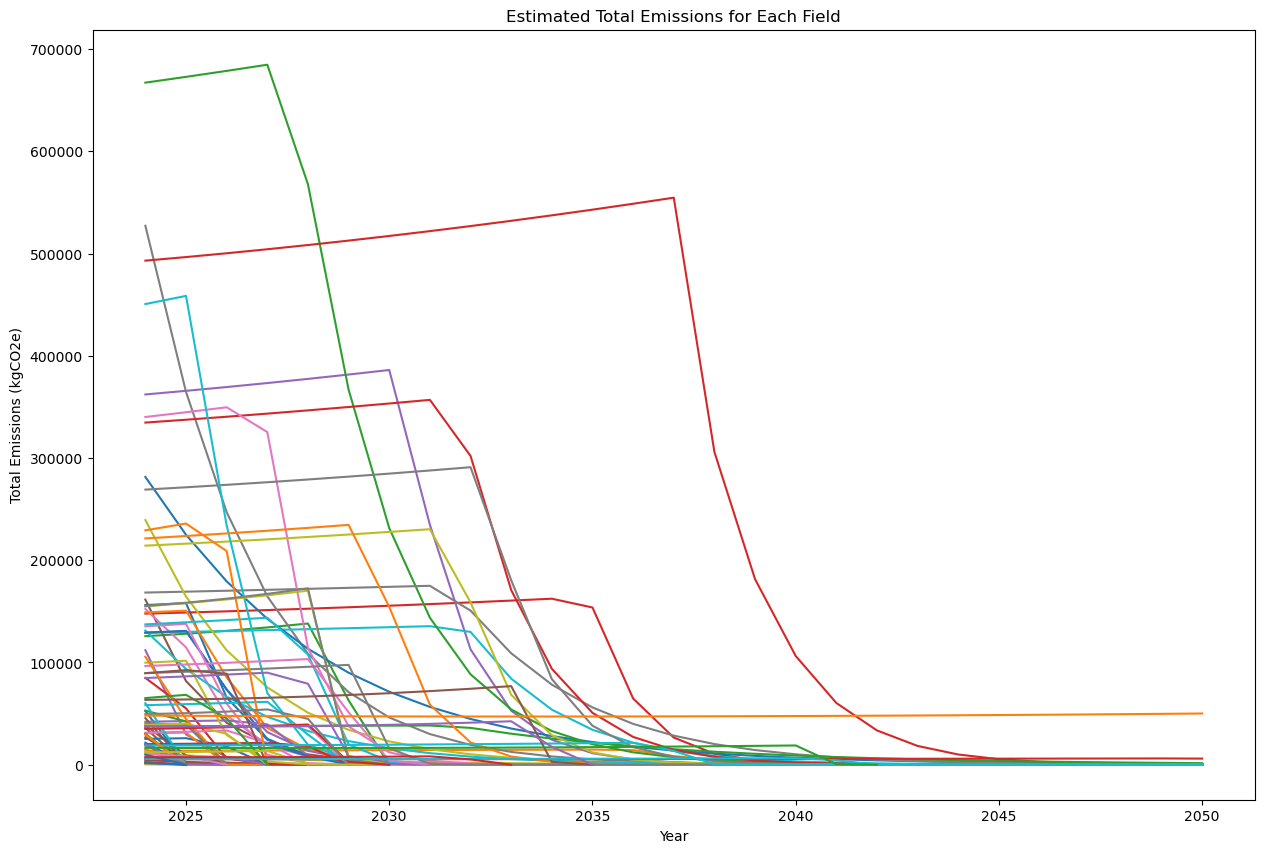

In [35]:
producing_data = data.copy()

# Filter for producing fields and calculate median yearly production
producing_data = producing_data[producing_data["current_remaining_recoverable_oe"] > 0]

# Calculate the mean emission intensity for each field
producing_data["mean_emission_intensity_distributed"] = producing_data.groupby("field")["emission_intensity_distributed"].transform("mean")

producing_data["mean_emission_intensity_distributed"].isna().sum()


def emission_intensity_adjustment(eq, x):
    a, b, c = eq["a"], eq["b"], eq["c"]
    return a * x**2 + b * x + c

# Define the ramp-down threshold
ramp_down_threshold = 0.05

# Print dataset information after preprocessing
print(f"Dataset shape after preprocessing: {producing_data.shape}")

# Simplified production forecast
future_years = list(range(2024, 2050))
fields = producing_data["field"].unique()

future_predictions = []

for field in fields:
    median_production = producing_data[producing_data["field"] == field]["median_production"].iloc[0]
    current_reserve = producing_data[producing_data["field"] == field]["current_remaining_recoverable_oe"].iloc[0]
    original_recoverable = producing_data[producing_data["field"] == field]["original_recoverable_oe"].iloc[0]
    current_emission_intensity = producing_data[producing_data["field"] == field]["mean_emission_intensity_distributed"].iloc[0]
    cumulative_production = 0
    year = 2024

    while current_reserve > 0 and year <= 2050:
        if current_reserve <= ramp_down_threshold * original_recoverable:
            production_for_year = max(median_production * (current_reserve / (ramp_down_threshold * original_recoverable)), 0)
        else:
            production_for_year = median_production if current_reserve >= median_production else current_reserve

        cumulative_production += production_for_year
        
        share_of_peak_prod = production_for_year / original_recoverable
        remaining_reserve_percentage = current_reserve / original_recoverable
        
        adjustment_1 = emission_intensity_adjustment(dml_1_equation, remaining_reserve_percentage * 100)
        adjustment_2 = emission_intensity_adjustment(dml_2_equation, share_of_peak_prod * 100)
        adjustment_3 = emission_intensity_adjustment(dml_3_equation, production_for_year)
        
        # Apply the adjustments with equal weighting
        final_emission_intensity = current_emission_intensity * (1 + (adjustment_1 + adjustment_2 + adjustment_3) / 3)
        
        # Apply the adjustments with equal weighting
        final_emission_intensity = current_emission_intensity * (1 + (adjustment_1 + adjustment_2 + adjustment_3) / 3)
        total_emissions = production_for_year * final_emission_intensity
        
        future_predictions.append({
            "field": field,
            "year": year,
            "predicted_production": production_for_year,
            "cumulative_production": cumulative_production,
            "total_emissions": total_emissions,
            "years_left": np.round(current_reserve / median_production, 0),
            "reserve": current_reserve,
            "mean_emission_intensity_distributed": current_emission_intensity,
        })
        current_reserve -= production_for_year
        year += 1

    if current_reserve <= 0:
        future_predictions.append({
            "field": field,
            "year": year,
            "predicted_production": 0,
            "cumulative_production": cumulative_production,
            "total_emissions": 0,
            "years_left": 0,
            "reserve": current_reserve,
            "mean_emission_intensity_distributed": current_emission_intensity,
        })

# Create a DataFrame for future predictions
future_predictions_df = pd.DataFrame(future_predictions)

# Plot the estimated total emissions for each field
plt.figure(figsize=(15, 10))
for field in future_predictions_df["field"].unique():
    field_data = future_predictions_df[future_predictions_df["field"] == field]
    plt.plot(field_data["year"], field_data["total_emissions"], label=field)

plt.xlabel("Year")
plt.ylabel("Total Emissions (kgCO2e)")
plt.title("Estimated Total Emissions for Each Field")
plt.show()

In [36]:
future_predictions_df

,field,year,predicted_production,cumulative_production,total_emissions,years_left,reserve,mean_emission_intensity_distributed
0,statfjord nord,2024,1.542401,1.542401,156151.785958,3.0,4.050000,336.019819
1,statfjord nord,2025,1.542401,3.084802,158096.887669,2.0,2.507599,336.019819
2,statfjord nord,2026,0.612391,3.697193,65653.808262,1.0,0.965198,336.019819
3,statfjord nord,2027,0.223846,3.921039,24442.849080,0.0,0.352807,336.019819
4,statfjord nord,2028,0.081822,4.002861,8994.494014,0.0,0.128961,336.019819
...,...,...,...,...,...,...,...,...
1319,fenja,2031,0.889540,7.116320,39959.596582,3.0,2.853220,166.260245
1320,fenja,2032,0.889540,8.005860,41123.872635,2.0,1.963680,166.260245
1321,fenja,2033,0.889540,8.895400,42503.166002,1.0,1.074140,166.260245
1322,fenja,2034,0.334779,9.230179,17543.559433,0.0,0.184600,166.260245


In [37]:
# Adding the electrified label from data

# Extracting only the last observation for each field
last_observation = producing_data.groupby("field").last().reset_index()

future_predictions_df = future_predictions_df.merge(last_observation[["field", "electrified"]], on="field", how="left")
future_predictions_df

,field,year,predicted_production,cumulative_production,total_emissions,years_left,reserve,mean_emission_intensity_distributed,electrified
0,statfjord nord,2024,1.542401,1.542401,156151.785958,3.0,4.050000,336.019819,0
1,statfjord nord,2025,1.542401,3.084802,158096.887669,2.0,2.507599,336.019819,0
2,statfjord nord,2026,0.612391,3.697193,65653.808262,1.0,0.965198,336.019819,0
3,statfjord nord,2027,0.223846,3.921039,24442.849080,0.0,0.352807,336.019819,0
4,statfjord nord,2028,0.081822,4.002861,8994.494014,0.0,0.128961,336.019819,0
...,...,...,...,...,...,...,...,...,...
1319,fenja,2031,0.889540,7.116320,39959.596582,3.0,2.853220,166.260245,0
1320,fenja,2032,0.889540,8.005860,41123.872635,2.0,1.963680,166.260245,0
1321,fenja,2033,0.889540,8.895400,42503.166002,1.0,1.074140,166.260245,0
1322,fenja,2034,0.334779,9.230179,17543.559433,0.0,0.184600,166.260245,0


In [38]:
# Export the future predictions to a CSV file
import os

filename_path = "../../data/output/emissions_and_production/cleaned/field_predictions.csv"

if not os.path.exists(filename_path):
    future_predictions_df.to_csv(filename_path, index=False)
    print("Saved file")
else:
    print("File already exists")


Saved file


In [39]:
# Printing the names of the electrified fields

future_predictions_df[future_predictions_df["electrified"] == 1]["field"].unique()

array(['hod', 'valhall', 'troll', 'gullfaks', 'sleipner øst', 'snorre',
       'ormen lange', 'gjøa', 'vega', 'edvard grieg', 'goliat',
       'gina krog', 'ivar aasen', 'johan sverdrup', 'martin linge',
       'duva', 'solveig', 'nova'], dtype=object)

### Regression


In [40]:
# Preparing the data

data["well_water_depth_mean_20m"] = data["well_water_depth_mean"] * 20

#

In [41]:
# Preprocess the Data: Remove np.nan and inf values
ols_data = data.replace([np.inf, -np.inf], np.nan).dropna()

# Define the dependent and independent variables
Y1 = ols_data["emission_intensity"]
Y2 = ols_data["emission_intensity_distributed"]

X = ols_data[
    [
        "share_peak_prod",
        "well_water_depth_mean_20m",
        "well_final_vertical_depth_mean",
        "original_recoverable_oe",
        "share_reserve_of_original_reserve",
        "net_oil_eq_prod_monthly_sm3_volatility",
        "gas_reserve_ratio",
        "oil_gas_reserve_ratio",
    ]
]

# Perform OLS regression using statsmodels for detailed results
ols_Y1 = sm.OLS(Y1, X).fit()
ols_Y2 = sm.OLS(Y2, X).fit()

# Conduct the OLS using sklearn for consistency with provided code
reg = LinearRegression().fit(X, Y2)

# Second degree polynomial regression
X_poly2 = X.copy()
for col in X.columns:
    if col != "const":
        X_poly2[f"{col}^2"] = X[col] ** 2

ols_Y1_poly2 = sm.OLS(Y1, X_poly2).fit()
ols_Y2_poly2 = sm.OLS(Y2, X_poly2).fit()


# Define a function to display the results in a pretty format
def pretty_print_results(results, degree):
    print(f"OLS Regression Results (Degree {degree}):")
    print("========================================")
    print(results.summary())
    print("\n\n")


# Print the results
pretty_print_results(ols_Y1, 1)
pretty_print_results(ols_Y2, 1)
pretty_print_results(ols_Y1_poly2, 2)
pretty_print_results(ols_Y2_poly2, 2)

OLS Regression Results (Degree 1):
                                 OLS Regression Results                                
Dep. Variable:     emission_intensity   R-squared (uncentered):                   0.297
Model:                            OLS   Adj. R-squared (uncentered):              0.289
Method:                 Least Squares   F-statistic:                              37.95
Date:                Thu, 25 Jul 2024   Prob (F-statistic):                    2.19e-50
Time:                        21:19:05   Log-Likelihood:                         -5495.9
No. Observations:                 726   AIC:                                  1.101e+04
Df Residuals:                     718   BIC:                                  1.104e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                                             coef    std err          t      P>|t|   

### Feature Importance


In [42]:
# Preprocess the Data: Remove np.nan and inf values
#ml_data = data.replace([np.inf, -np.inf], np.nan).dropna()

ml_data = data.copy()

# Define the dependent and independent variables
Y1 = ml_data["yearly_tco2e_prod_share_emissions"]

X = ml_data[
    [
        "year",
        "field",
        "share_peak_prod",
        "well_water_depth_mean",
        "well_final_vertical_depth_mean",
        "current_remaining_recoverable_oe",
        "original_recoverable_oe",
        "original_recoverable_gas",
        "original_recoverable_ngl",
        "original_recoverable_condensate",
        "share_reserve_of_original_reserve",
        "net_oil_eq_prod_monthly_sm3_volatility",
        "net_oil_eq_prod_yearly_mill_sm3",
        "gas_reserve_ratio",
        "oil_gas_reserve_ratio",
        "electrified",
        "operator",
        "investments_mill_nok",
        "future_investments_mill_nok",
        "current_remaining_recoverable_oil",
        "current_remaining_recoverable_gas",
        "current_remaining_recoverable_ngl",
        "current_remaining_recoverable_condensate",
        "well_subsea_yes",
        "well_subsea_no",
        "facility_kind_multi well template",
        "facility_kind_single well template",
        "facility_kind_offshore wind turbine",
        "facility_kind_subsea structure",
        "facility_kind_fpso",
        "facility_kind_jacket 8 legs",
        "facility_kind_condeep monoshaft",
        "facility_kind_loading system",
        "facility_kind_jacket 4 legs",
        "facility_kind_jacket tripod",
        "facility_kind_fsu",
        "facility_kind_semisub steel",
        "facility_kind_condeep 4 shafts",
        "facility_kind_landfall",
        "facility_kind_tlp concrete",
        "facility_kind_jack-up 3 legs",
        "facility_kind_jacket 6 legs",
        "facility_kind_tlp steel",
        "facility_kind_semisub concrete",
        "facility_kind_mopustor",
        "facilities_water_depth_mean",
        "facilities_water_depth_std",
        "status",
        "well_status_closed",
        "well_status_drilling",
        "well_status_injecting",
        "well_status_junked",
        "well_status_online/operational",
        "well_status_p&a",
        "well_status_plugged",
        "well_status_producing",
        "well_status_suspended",
        "well_purpose_injection",
        "well_purpose_observation",
        "well_purpose_production",
    ]
]

# Convert dummies
X = pd.get_dummies(X, columns=["operator", "field", "status"], drop_first=True)

# Ensure all columns are numeric
X = X.apply(pd.to_numeric)

# Standardize the independent variables
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)
X_standardized = pd.DataFrame(X_standardized, columns=X.columns, index=X.index)

# Align indices between Y1 and X_standardized
Y1 = Y1.loc[X_standardized.index]

# OLS regression with original variables
ols_Y1 = sm.OLS(Y1, sm.add_constant(X_standardized)).fit()

# Conduct the OLS using sklearn for consistency with provided code
reg = LinearRegression().fit(X_standardized, Y1)

# Cross-validation for OLS model
cv_scores = cross_val_score(reg, X_standardized, Y1, cv=5, scoring="r2")
print("Cross-validated R-squared for OLS model:", cv_scores.mean())

# XGBoost regression
xgb = XGBRegressor(objective="reg:squarederror", random_state=42)
xgb.fit(X_standardized, Y1)
y_pred_xgb = xgb.predict(X_standardized)

# Evaluate the model
mse = mean_squared_error(Y1, y_pred_xgb)
r2 = r2_score(Y1, y_pred_xgb)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.3f}")

# Hyperparameter Tuning for XGBoost
param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}

grid_search = GridSearchCV(
    estimator=xgb, param_grid=param_grid, cv=5, scoring="r2", n_jobs=-1
)
grid_search.fit(X_standardized, Y1)

print(f"Best parameters found: {grid_search.best_params_}")
best_xgb = grid_search.best_estimator_

# Evaluate the tuned model
y_pred_best_xgb = best_xgb.predict(X_standardized)
mse_best = mean_squared_error(Y1, y_pred_best_xgb)
r2_best = r2_score(Y1, y_pred_best_xgb)
print(f"Mean Squared Error (Tuned): {mse_best:.2f}")
print(f"R-squared (Tuned): {r2_best:.3f}")

# Feature importance
importance = best_xgb.feature_importances_
features = X.columns
importance_df = pd.DataFrame({"Feature": features, "Importance": importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Extract coefficients from the linear regression model
coefficients = pd.DataFrame({"Feature": X.columns, "Coefficient": reg.coef_})

# Adding the coefficients to the importance DataFrame
importance_df = importance_df.merge(coefficients, on="Feature")

# LIME for interpretability
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_standardized),
    feature_names=X.columns,
    class_names=["yearly_tco2e_prod_share_emissions"],
    mode="regression",
)

# Explain a single prediction
i = 0  # Index of the instance to explain
exp = explainer.explain_instance(
    X_standardized.iloc[i], best_xgb.predict, num_features=10
)
exp.show_in_notebook(show_table=True)

# VIF Calculation
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [
    variance_inflation_factor(X.values, i) for i in range(len(X.columns))
]
print(vif_data)

# Filtering out the features with VIF
high_vif_features = vif_data[vif_data["VIF"] > 20]["Feature"].values

# Remove variables with high VIF
X_reduced = X.drop(columns=high_vif_features)

# Perform PCA to reduce multicollinearity
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X_reduced)

# Standardize the PCA components
scaler_pca = StandardScaler()
X_pca_standardized = scaler_pca.fit_transform(X_pca)

# Conduct regression with PCA components
ols_Y1_pca = sm.OLS(Y1, sm.add_constant(X_pca_standardized)).fit()
print(ols_Y1_pca.summary())

# Ridge Regression
ridge = RidgeCV(alphas=np.logspace(-6, 6, 13)).fit(X_standardized, Y1)
print(f"Ridge Regression coefficients: {ridge.coef_}")

# Combine and compare OLS and Ridge coefficients
ridge_coefficients = pd.DataFrame(
    {"Feature": X.columns, "Ridge_Coefficient": ridge.coef_}
)
combined_coefficients = coefficients.merge(ridge_coefficients, on="Feature")

# Filter importance_df to include only features within VIF limit
importance_df = importance_df[importance_df["Feature"].isin(X_reduced.columns)]

# Add combined_coeff to importance_df
importance_df = importance_df.merge(combined_coefficients, on="Feature")

vif_data_filtered = vif_data[vif_data["Feature"].isin(X_reduced.columns)]
importance_df = importance_df.merge(vif_data_filtered, on="Feature")

importance_df.head(50)

ValueError: Input X contains infinity or a value too large for dtype('float64').